# Descriptive Analysis

In [15]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
pd.set_option("display.max_rows", 20)

import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import clear_output

In [16]:
train = pd.read_csv("../input/walmart-recruiting-store-sales-forecasting/train.csv.zip")
features = pd.read_csv('../input/walmart-recruiting-store-sales-forecasting/features.csv.zip')
sample = pd.read_csv('../input/walmart-recruiting-store-sales-forecasting/sampleSubmission.csv.zip')
stores  = pd.read_csv('../input/walmart-recruiting-store-sales-forecasting/stores.csv')
test = pd.read_csv('../input/walmart-recruiting-store-sales-forecasting/test.csv.zip')

In [17]:
print(test.Date.nunique())

39


In [18]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 421570 entries, 0 to 421569
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Store         421570 non-null  int64  
 1   Dept          421570 non-null  int64  
 2   Date          421570 non-null  object 
 3   Weekly_Sales  421570 non-null  float64
 4   IsHoliday     421570 non-null  bool   
dtypes: bool(1), float64(1), int64(2), object(1)
memory usage: 13.3+ MB


In [19]:
features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8190 entries, 0 to 8189
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Store         8190 non-null   int64  
 1   Date          8190 non-null   object 
 2   Temperature   8190 non-null   float64
 3   Fuel_Price    8190 non-null   float64
 4   MarkDown1     4032 non-null   float64
 5   MarkDown2     2921 non-null   float64
 6   MarkDown3     3613 non-null   float64
 7   MarkDown4     3464 non-null   float64
 8   MarkDown5     4050 non-null   float64
 9   CPI           7605 non-null   float64
 10  Unemployment  7605 non-null   float64
 11  IsHoliday     8190 non-null   bool   
dtypes: bool(1), float64(9), int64(1), object(1)
memory usage: 712.0+ KB


In [20]:
stores.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45 entries, 0 to 44
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Store   45 non-null     int64 
 1   Type    45 non-null     object
 2   Size    45 non-null     int64 
dtypes: int64(2), object(1)
memory usage: 1.2+ KB


In [21]:
## Creating calendar function
def cal (start, end):
    df_cal= pd.DataFrame({"date": pd.date_range(start, end)})
    df_cal["year"] = df_cal.date.dt.year
    df_cal["month"]= df_cal.date.dt.month
    df_cal['year_month'] = pd.to_datetime(df_cal['date']).dt.to_period('M')
    df_cal["week_num"]= df_cal.date.dt.week
    #df_cal["week_day"]= df_cal.date.dt.weekday
    #df_cal["week_day_name"]= df_cal.date.dt.weekday_name
    #df_cal["day_of_year"]= df_cal.date.dt.dayofyear
    #df_cal['date'] = df_cal['date'].dt.strftime('%Y-%m-%d')
    return df_cal

In [22]:
pd.to_datetime(train.Date[0], format = '%Y-%m-%d').strftime('%A')

'Friday'

In [23]:
# Assigning frequency 
train.Date = pd.to_datetime(train.Date, format = '%Y-%m-%d')
train.Date.freq = 'W-FRI'

In [24]:
# Genearint calandar by use of calender function with start and end date
# of our train set
train_d = train.Date.unique()
train_d.sort(axis = 0)
train_cal = cal(train_d[0], train_d[-1])

# merge calendar to train set
train_d = pd.merge(train, train_cal, left_on = 'Date', right_on = 'date', how = 'left')
train_d = train_d.drop('date', axis = 1)
#train_d.head(1)

# Assigning frequency to features set
features.Date = pd.to_datetime(features.Date, format = '%Y-%m-%d')
features.Date.freq = 'W-FRI'

tfd = pd.merge (train_d[[i for i in train_d.columns if i not in ['IsHoliday']]], features, left_on = ['Date', 'Store'], right_on = ['Date', 'Store'], how = 'left')
tfd = pd.merge(tfd,stores, how = 'left',  left_on= 'Store', right_on = 'Store')

In [25]:
tfd.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 421570 entries, 0 to 421569
Data columns (total 20 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   Store         421570 non-null  int64         
 1   Dept          421570 non-null  int64         
 2   Date          421570 non-null  datetime64[ns]
 3   Weekly_Sales  421570 non-null  float64       
 4   year          421570 non-null  int64         
 5   month         421570 non-null  int64         
 6   year_month    421570 non-null  period[M]     
 7   week_num      421570 non-null  int64         
 8   Temperature   421570 non-null  float64       
 9   Fuel_Price    421570 non-null  float64       
 10  MarkDown1     150681 non-null  float64       
 11  MarkDown2     111248 non-null  float64       
 12  MarkDown3     137091 non-null  float64       
 13  MarkDown4     134967 non-null  float64       
 14  MarkDown5     151432 non-null  float64       
 15  CPI           421

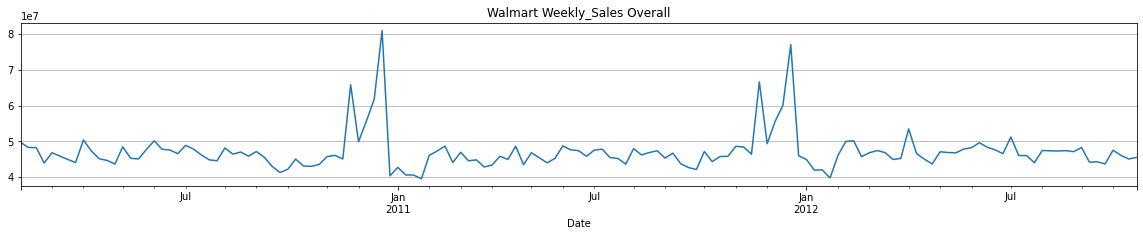

In [26]:
ov_sales = tfd.groupby('Date').Weekly_Sales.sum()
ov_sales.plot(figsize = (20,3))
plt.title ('Walmart Weekly_Sales Overall')
plt.grid(axis = 'y', which = 'both');

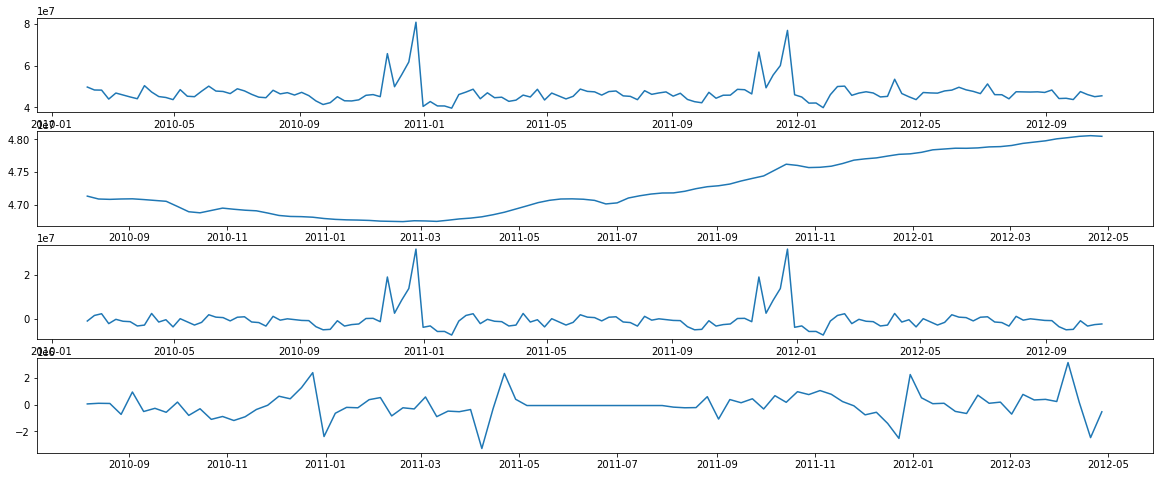

In [27]:
from statsmodels.tsa.seasonal import seasonal_decompose as sd
y = tfd.groupby('Date').Weekly_Sales.sum()
y.index.freg = 'M-FRI'
dec = sd(y, model='additive')
f,ax = plt.subplots(4, figsize =(20,8))
ax[0].plot(dec.observed)
ax[1].plot(dec.trend)
ax[2].plot(dec.seasonal)
ax[3].plot(dec.resid)

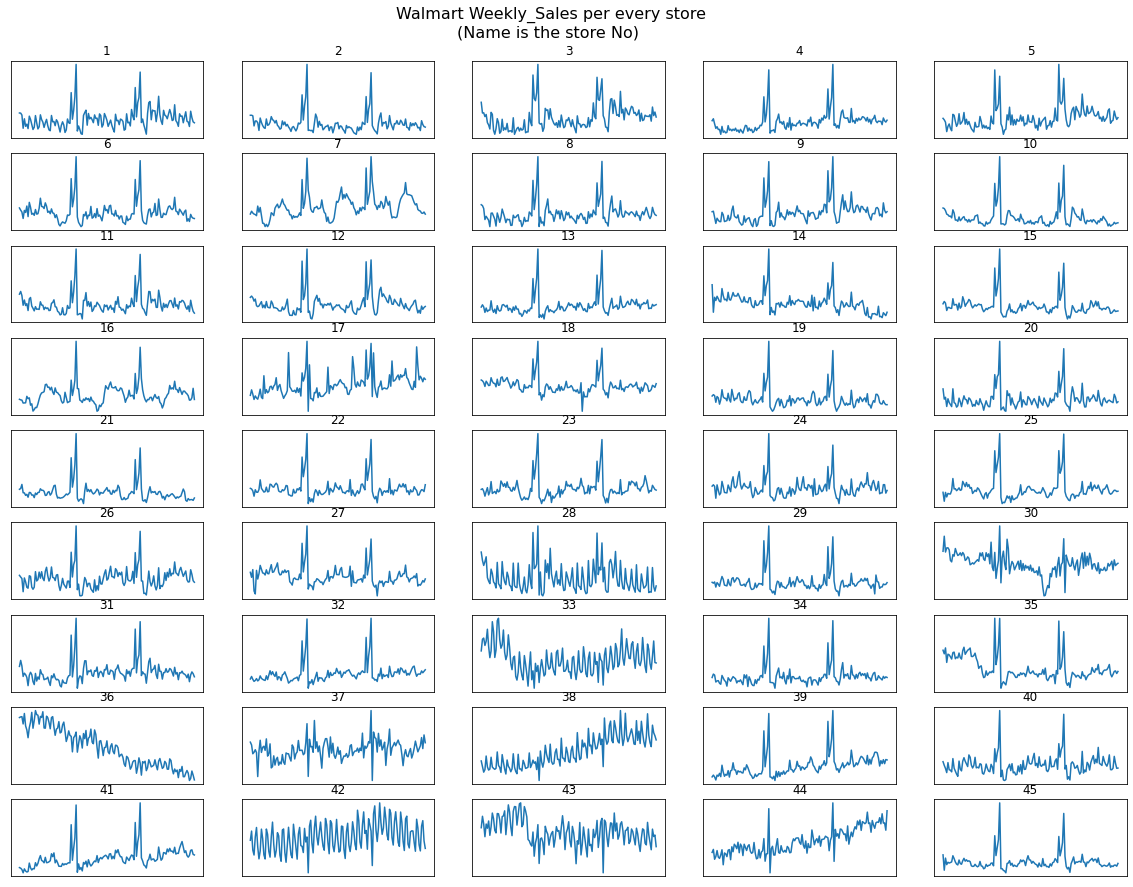

In [28]:
fig = plt.figure(figsize = (20,15))
fig.suptitle('Walmart Weekly_Sales per every store\n(Name is the store No) ',y = 0.93,  fontsize = 16)
for s in list(range(1,46)):
    df_un0=tfd[tfd.Store == s].groupby('Date').Weekly_Sales.sum()
    ax = fig.add_subplot(9,5,s)
    #ax.plot(df_un0[:-len_pred])
    ax.plot(df_un0)
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)
    ax.set_title(s)
plt.show()

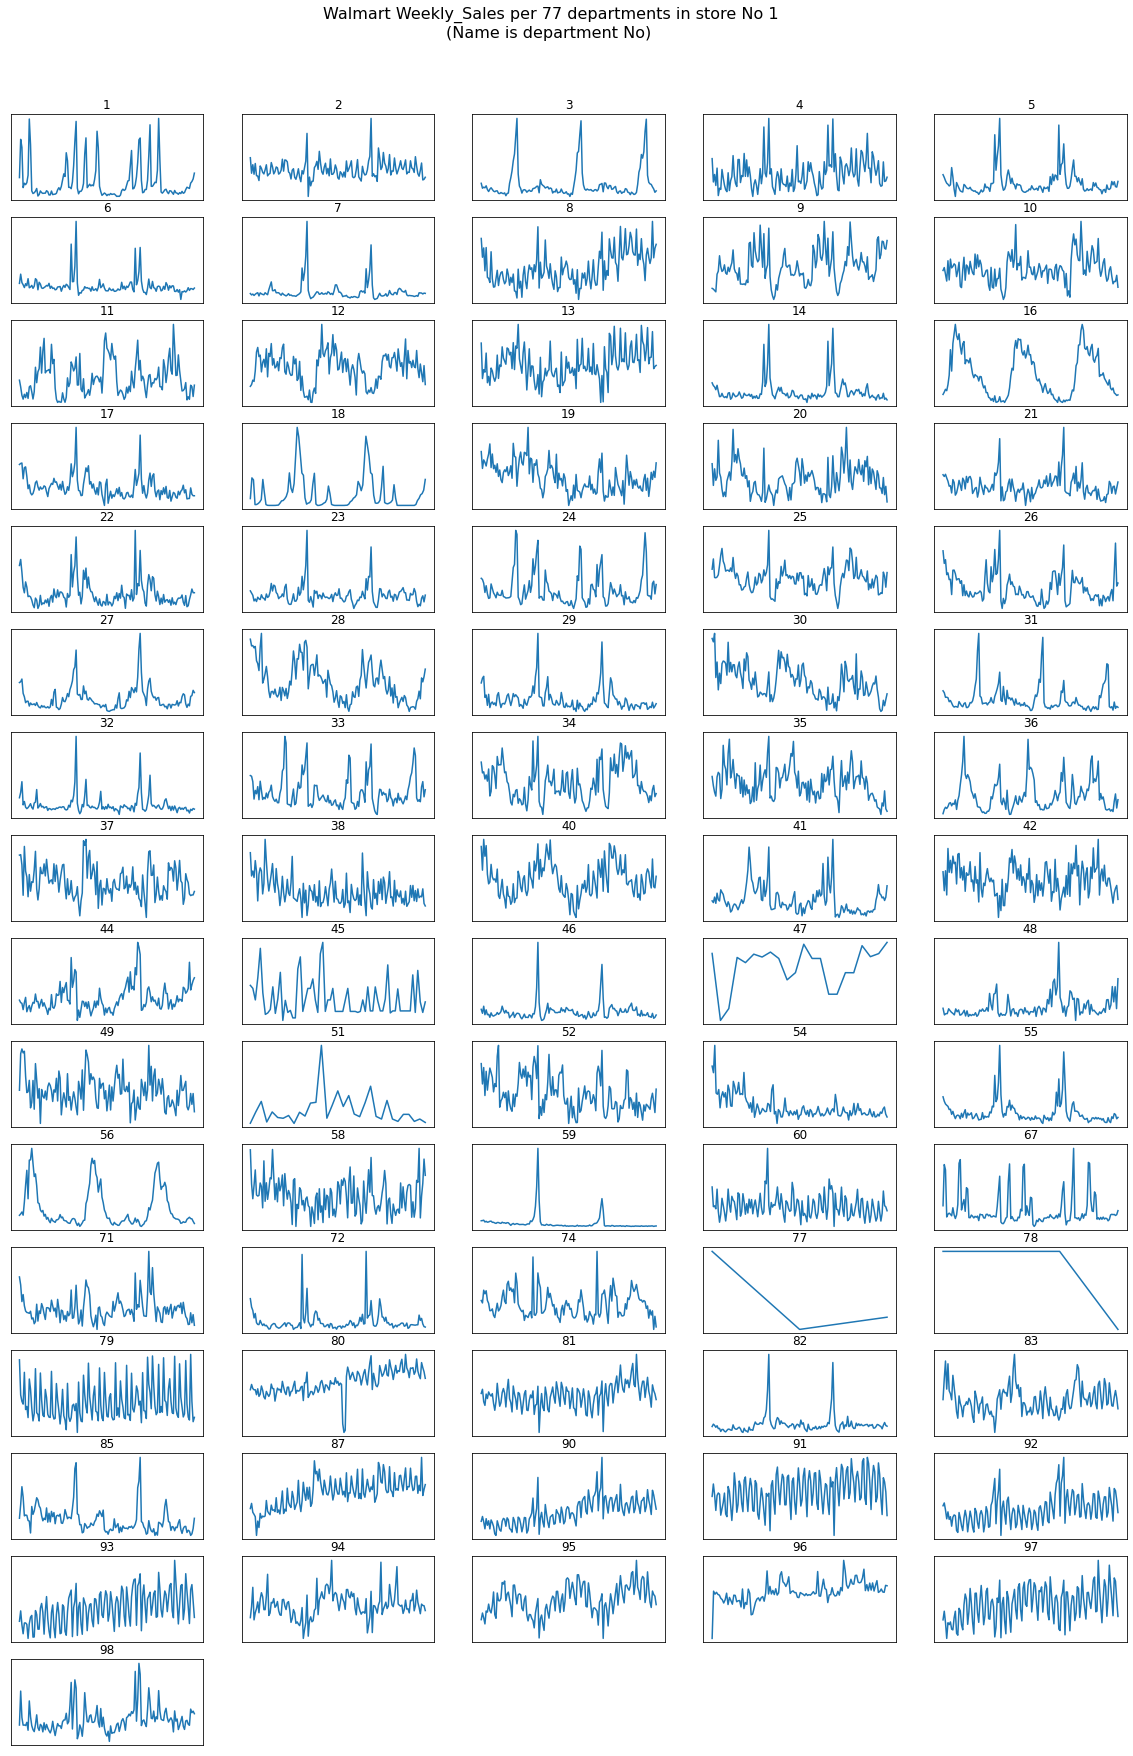

In [29]:
store_num = 1
s1 = tfd[tfd.Store == store_num][['Date', 'Dept', 'Weekly_Sales']]
fig = plt.figure(figsize = (20,30))
fig.suptitle(f'Walmart Weekly_Sales per {len(s1.Dept.unique())} departments in store No {store_num}\n(Name is department No) ',y = 0.93,  fontsize = 16)
for dep, num_in_plot in  zip(s1.Dept.unique(), list(range(1,len(s1.Dept.unique())))):
    df_un0=s1[s1.Dept == dep]
    df_un0.set_index('Date')
    df_un0 = df_un0[['Weekly_Sales']]
    ax = fig.add_subplot(16,5,num_in_plot)
    #ax.plot(df_un0[:-len_pred])
    ax.plot(df_un0)
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)
    ax.set_title(dep)
plt.show()

In [30]:
# encode the 'Isholiday' feature
tfd['hol_num'] = tfd['IsHoliday'].apply(lambda x: 0 if x is False else 1 if x is True else x)
tfd['Type_num'] = tfd.Type.astype('category').cat.codes

In [31]:
tfd.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 421570 entries, 0 to 421569
Data columns (total 22 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   Store         421570 non-null  int64         
 1   Dept          421570 non-null  int64         
 2   Date          421570 non-null  datetime64[ns]
 3   Weekly_Sales  421570 non-null  float64       
 4   year          421570 non-null  int64         
 5   month         421570 non-null  int64         
 6   year_month    421570 non-null  period[M]     
 7   week_num      421570 non-null  int64         
 8   Temperature   421570 non-null  float64       
 9   Fuel_Price    421570 non-null  float64       
 10  MarkDown1     150681 non-null  float64       
 11  MarkDown2     111248 non-null  float64       
 12  MarkDown3     137091 non-null  float64       
 13  MarkDown4     134967 non-null  float64       
 14  MarkDown5     151432 non-null  float64       
 15  CPI           421

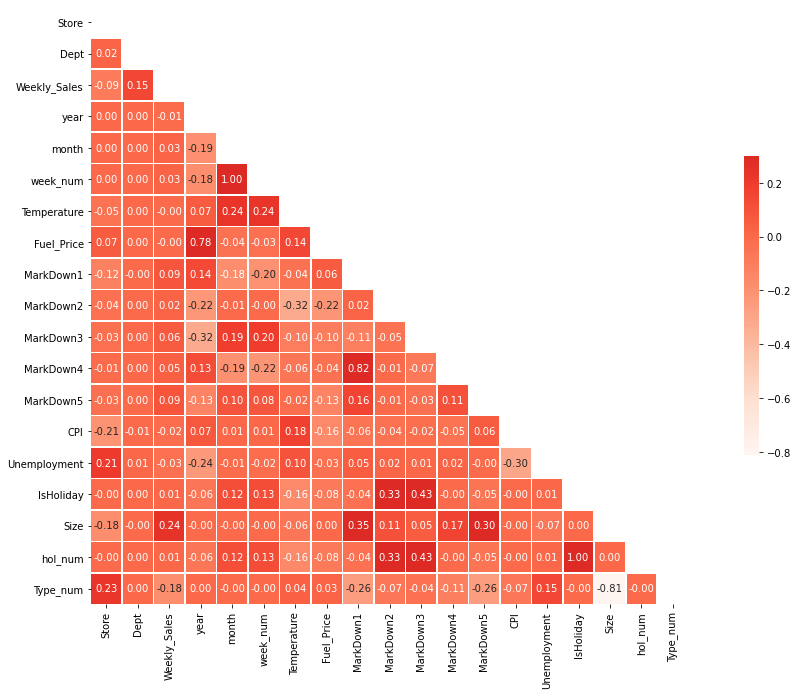

In [32]:
import seaborn as sns
tfd_corr = tfd.corr()
mask = np.triu(np.ones_like(tfd_corr, dtype=np.bool))

plt.subplots(figsize=(20, 11))
#cmap = sns.diverging_palette(220, 10, as_cmap=True)

sns.heatmap(tfd_corr, mask=mask,vmax=.3, center=0, square=True,cmap="Reds",annot = True,fmt='.2f', linewidths=.6, cbar_kws={"shrink": .5});

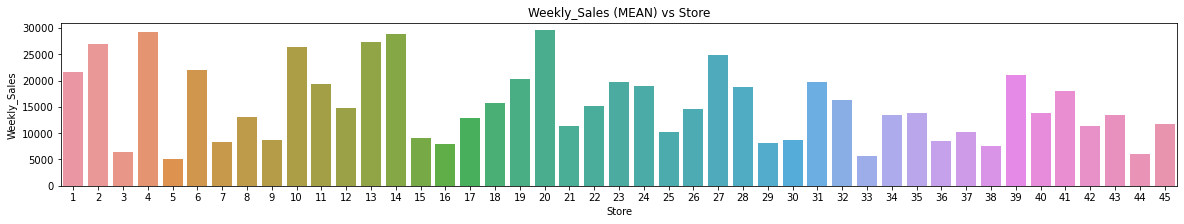

In [33]:
# Weekly_Sales vs Store
fig= plt.figure(figsize = (20,3))
df_g = tfd.groupby('Store')['Weekly_Sales'].mean().reset_index()
ax = sns.barplot(y = df_g.Weekly_Sales, x = df_g.Store)
plt.title('Weekly_Sales (MEAN) vs Store');

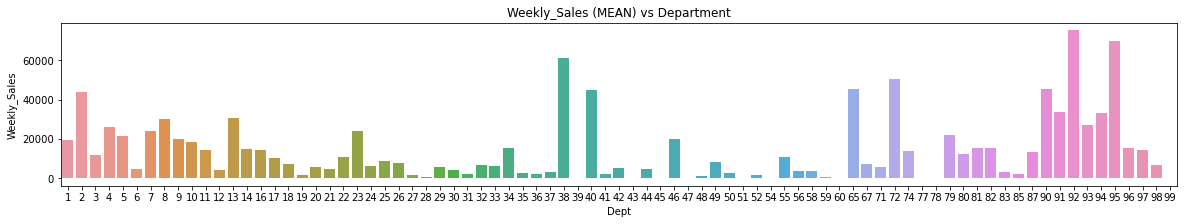

In [34]:
# Weekly_Sales vs Department
fig= plt.figure(figsize = (20,3))
df_g = tfd.groupby('Dept')['Weekly_Sales'].mean().reset_index()
ax = sns.barplot(y = df_g.Weekly_Sales, x = df_g.Dept)
plt.title('Weekly_Sales (MEAN) vs Department');

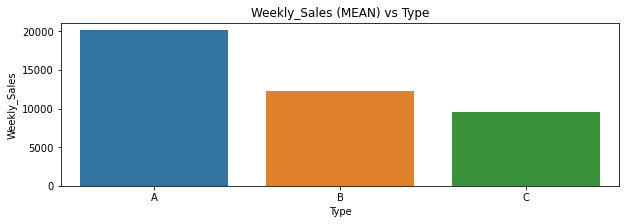

In [35]:
# Weekly_Sales vs Type
fig= plt.figure(figsize = (10,3))
df_g = tfd.groupby('Type')['Weekly_Sales'].mean().reset_index()
ax = sns.barplot(y = df_g.Weekly_Sales, x = df_g.Type)
plt.title('Weekly_Sales (MEAN) vs Type');

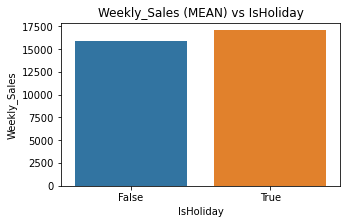

In [36]:
fig= plt.figure(figsize = (5,3))
df_g = tfd.groupby('IsHoliday')['Weekly_Sales'].mean().reset_index()
ax = sns.barplot(y = df_g.Weekly_Sales, x = df_g.IsHoliday)
plt.title('Weekly_Sales (MEAN) vs IsHoliday');

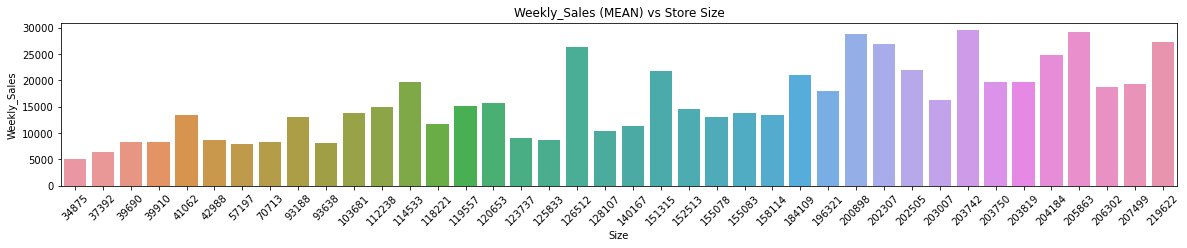

In [37]:
# Weekly_Sales vs Size
fig= plt.figure(figsize = (20,3))
df_g = tfd.groupby('Size')['Weekly_Sales'].mean().reset_index()
ax = sns.barplot(y = df_g.Weekly_Sales, x = df_g.Size)
plt.xticks (rotation = 45)
plt.title('Weekly_Sales (MEAN) vs Store Size');



 Weekly Sales Vs Cpi & Unemployment rate



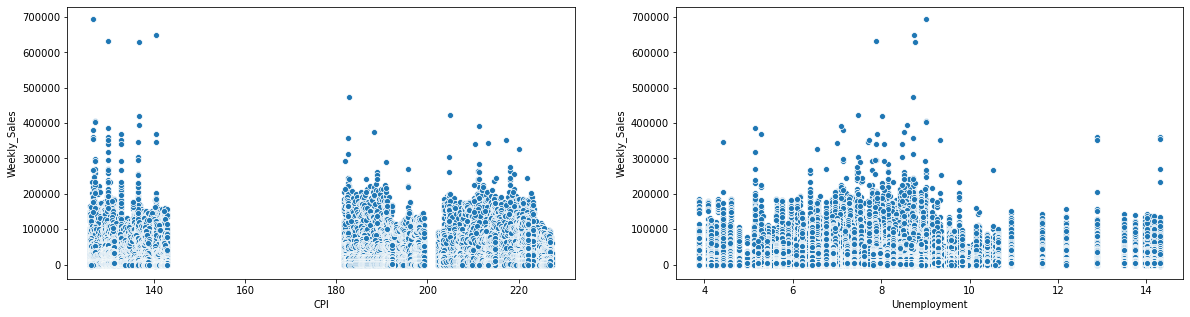

In [38]:
fig, ax= plt.subplots(1,2, figsize = (20,5))
sns.scatterplot(y = tfd.Weekly_Sales, x = tfd.CPI, ax = ax[0])
sns.scatterplot(y = tfd.Weekly_Sales, x = tfd.Unemployment, ax = ax[1]);

print('\n\n Weekly Sales Vs Cpi & Unemployment rate\n')

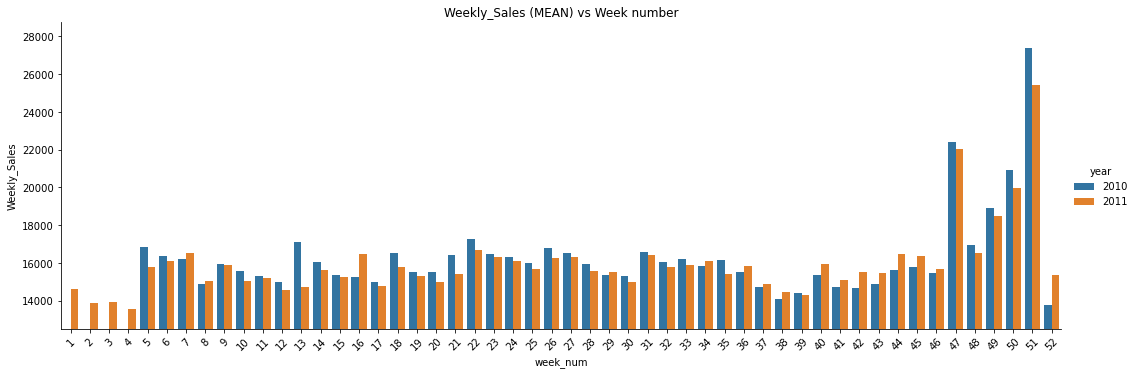

In [39]:
df_week = tfd[tfd.year<2012].groupby(['year','week_num'])['Weekly_Sales'].mean().reset_index()
ax = sns.catplot(data = df_week, y = 'Weekly_Sales', x = 'week_num', hue = 'year', kind = 'bar', height=5, aspect = 3)
plt.xticks (rotation = 45)
plt.ylim(12500)
plt.title('Weekly_Sales (MEAN) vs Week number');

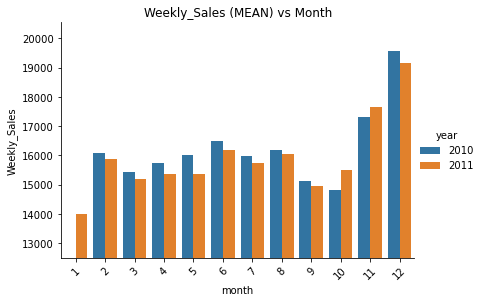

In [40]:
df_month = tfd[tfd.year<2012].groupby(['year','month'])['Weekly_Sales'].mean().reset_index()
ax = sns.catplot(data = df_month, y = 'Weekly_Sales', x = 'month', hue = 'year', kind = 'bar', height=4, aspect = 1.5)
plt.xticks (rotation = 45)
plt.ylim(12500)
plt.title('Weekly_Sales (MEAN) vs Month');

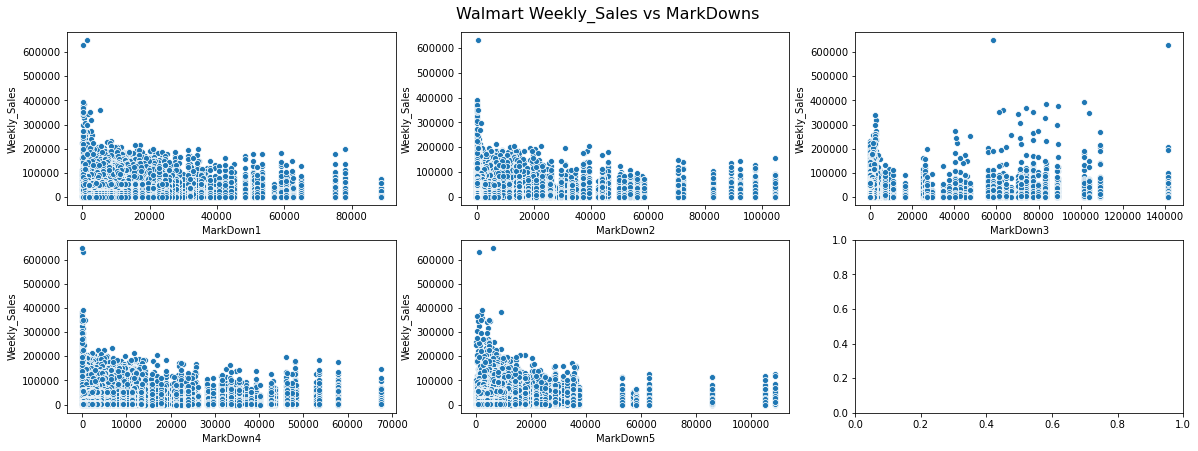

In [41]:
fig, ax = plt.subplots(2,3, figsize = (20,7))
fig.suptitle('Walmart Weekly_Sales vs MarkDowns',y = 0.93,  fontsize = 16)
sns.scatterplot(y = tfd.Weekly_Sales, x =tfd.MarkDown1, ax = ax[0,0])
sns.scatterplot(y = tfd.Weekly_Sales, x =tfd.MarkDown2, ax = ax[0,1])
sns.scatterplot(y = tfd.Weekly_Sales, x =tfd.MarkDown3, ax = ax[0,2])
sns.scatterplot(y = tfd.Weekly_Sales, x =tfd.MarkDown4, ax = ax[1,0])
sns.scatterplot(y = tfd.Weekly_Sales, x =tfd.MarkDown5, ax = ax[1,1])
plt.show()

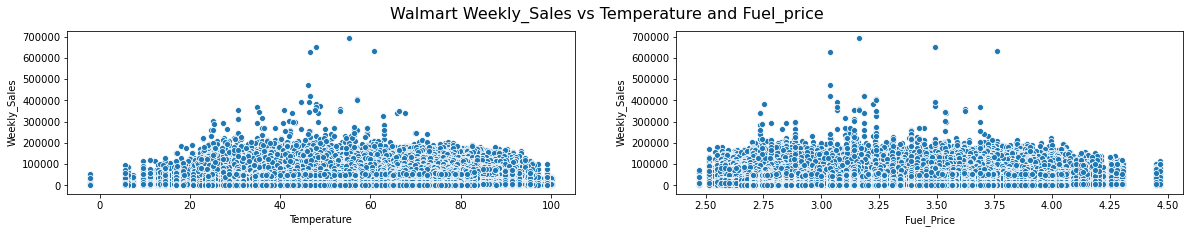

In [42]:
fig, ax = plt.subplots(ncols = 2, figsize = (20,3))
fig.suptitle('Walmart Weekly_Sales vs Temperature and Fuel_price',y = 0.99,  fontsize = 16)
sns.scatterplot(y = tfd.Weekly_Sales, x =tfd.Temperature, ax = ax[0])
sns.scatterplot(y = tfd.Weekly_Sales, x =tfd.Fuel_Price, ax = ax[1]);

In [43]:
tfd_fil =tfd.drop(['MarkDown1','MarkDown2','MarkDown3','MarkDown4','MarkDown5', 
          'Unemployment', 'CPI', 'IsHoliday', 'Type', 'Temperature', 'Fuel_Price','year_month'], axis = 1)
tfd_fil = tfd_fil[['Date', 'Store', 'Dept','year','month','week_num','hol_num','Size','Type_num','Weekly_Sales']]
#final version of our train dataset
tfd_fil.head(5)

,Date,Store,Dept,year,month,week_num,hol_num,Size,Type_num,Weekly_Sales
0,2010-02-05,1,1,2010,2,5,0,151315,0,24924.50
1,2010-02-12,1,1,2010,2,6,1,151315,0,46039.49
2,2010-02-19,1,1,2010,2,7,0,151315,0,41595.55
3,2010-02-26,1,1,2010,2,8,0,151315,0,19403.54
4,2010-03-05,1,1,2010,3,9,0,151315,0,21827.90


# Machine Learning 

In [44]:
print(test.Date.nunique())

39


In [45]:
from sklearn.model_selection import train_test_split

threshold_date = pd.to_datetime(tfd_fil.Date.unique()[-test.Date.nunique()]).strftime('%Y-%m-%d')

all_train = tfd_fil[tfd_fil.Date<threshold_date]
all_test = tfd_fil[tfd_fil.Date>=threshold_date]

X_train = all_train.drop(['Date','Weekly_Sales'], axis = 1)
X_test = all_test.drop(['Date','Weekly_Sales'], axis = 1)

y_train = all_train['Weekly_Sales']
y_test = all_test['Weekly_Sales']


#Feature Scaling
from sklearn.preprocessing import MinMaxScaler
mms = MinMaxScaler()
mms.fit(X_train)
X_train_sc = mms.transform(X_train)
X_test_sc = mms.transform(X_test)


In [46]:
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
from sklearn.metrics import  r2_score

clf = RandomForestRegressor(n_estimators=100, max_samples = 0.4)
clf.fit(X_train_sc, y_train)
clf_pred = clf.predict(X_test_sc)

print('Results with NO differentiation')
print('Weekly_Sales_Mean_test:' ,round(np.mean(y_test) ))
print('Root Mean Squared Error:', round(np.sqrt(metrics.mean_squared_error(y_test, clf_pred))))
print('R2 Score:', r2_score(y_test, clf_pred))

Results with NO differentiation
Weekly_Sales_Mean_test: 15843
Root Mean Squared Error: 3331
R2 Score: 0.977428054617968


In [47]:
rf_pr = pd.DataFrame({'Weekly_Sales':y_test.values, 'Weekly_Sales_rf_pred': clf_pred}, index = y_test.index)
rf_pred_df = pd.merge(rf_pr, tfd_fil[['Date', 'Store', 'Dept']], left_index = True, right_index = True, how = 'left')

In [48]:
rf_pred_df.head(2)

,Weekly_Sales,Weekly_Sales_rf_pred,Date,Store,Dept
104,23510.49,23650.5903,2012-02-03,1,1
105,36988.49,38446.8772,2012-02-10,1,1


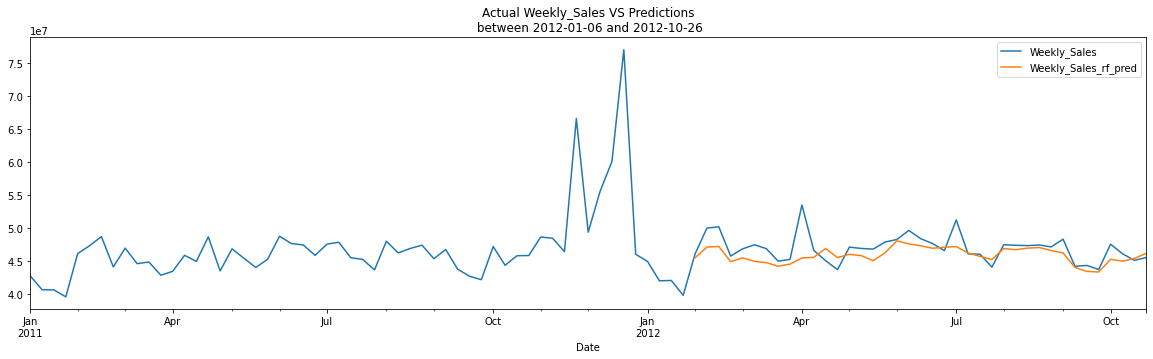

In [49]:
pred_g = rf_pred_df.groupby('Date')['Weekly_Sales','Weekly_Sales_rf_pred'].sum()
act_g = tfd_fil.groupby('Date')['Weekly_Sales'].sum()

ax = act_g[act_g.index>'2011-01-01'].plot(figsize = (20,5), legend = True)
pred_g['Weekly_Sales_rf_pred'].plot(legend = True)


threshold_date = tfd_fil[tfd_fil.Date>'2012-01-01']['Date'].iloc[0].strftime('%Y-%m-%d')
end_date =tfd_fil[tfd_fil.Date>'2012-01-01']['Date'].iloc[-1].strftime('%Y-%m-%d')

plt.title(f'Actual Weekly_Sales VS Predictions\n between {threshold_date} and {end_date}');

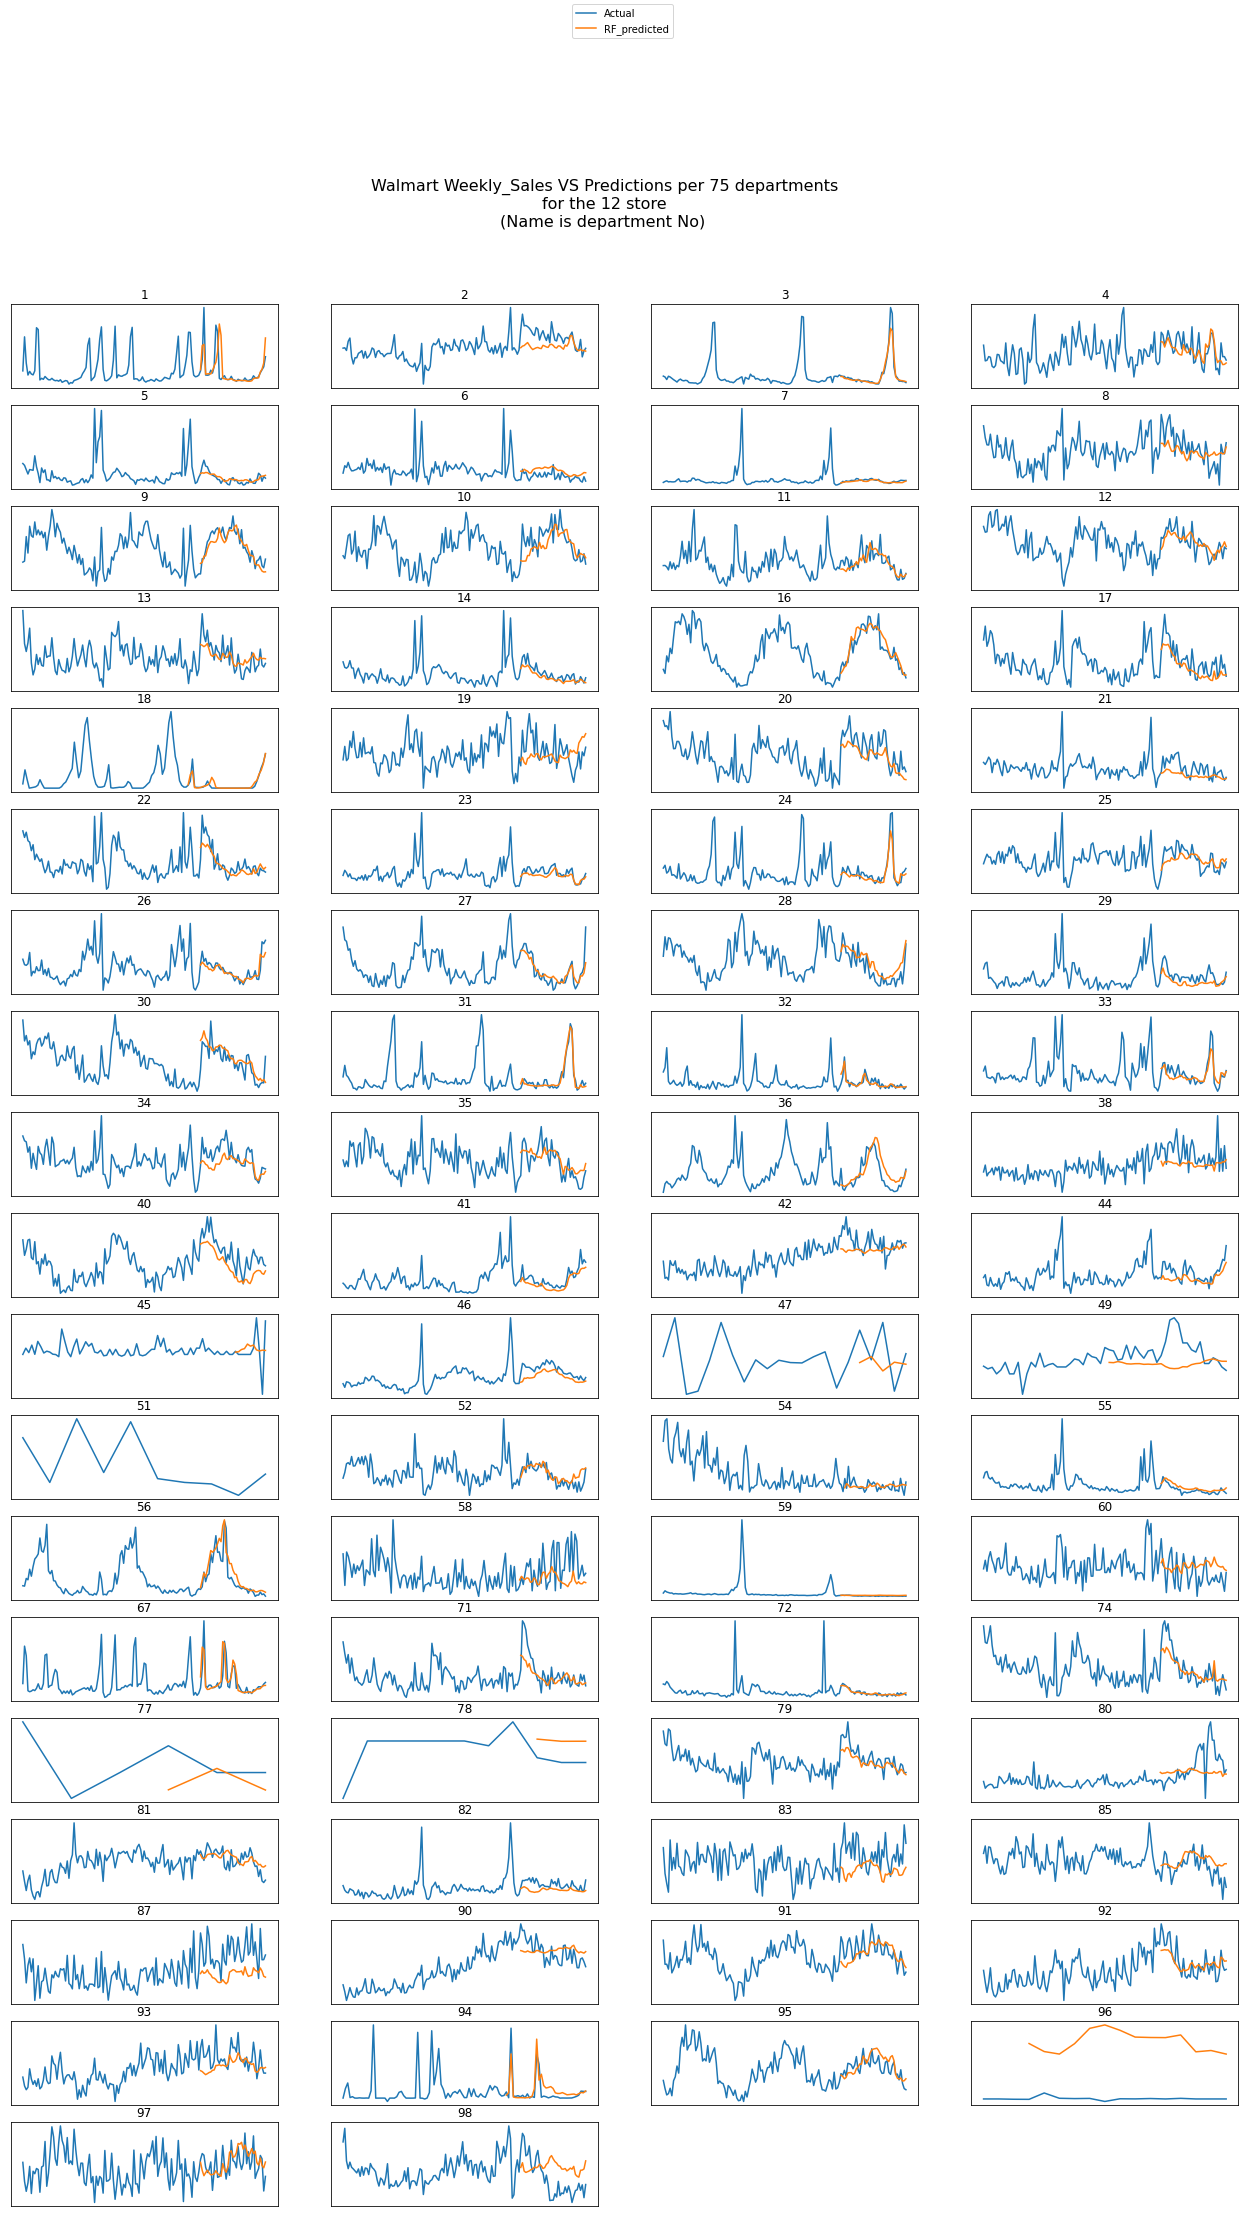

In [50]:
#tfd_fil_pred_start
#tfd_fil
st = 12
s1 = tfd_fil[tfd_fil.Store == st]
fig = plt.figure(figsize = (22,35))
fig.suptitle(f'Walmart Weekly_Sales VS Predictions per {len(s1.Dept.unique())} departments\nfor the {st} store\n(Name is department No) ',y = 0.93,  fontsize = 16)

for dep, num_in_plot in  zip(s1.Dept.unique(), list(range(1,len(s1.Dept.unique())))):
    
    #actual
    act =tfd_fil[(tfd_fil.Store ==st)&(tfd_fil.Dept == dep)]
    act.set_index('Date')
    
    #pred 
    
    pred = rf_pred_df[(rf_pred_df.Store ==st )&(rf_pred_df.Dept == dep)]
    pred.set_index('Date')
    
    ax = fig.add_subplot(19,4,num_in_plot)
    #ax.plot(df_un0[:-len_pred])
    
    ax.plot(act['Weekly_Sales'])
    ax.plot (pred['Weekly_Sales_rf_pred'])
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)
    ax.set_title(dep)
    #handles, labels = ax.get_legend_handles_labels()
fig.legend(labels = ('Actual','RF_predicted'), loc=9) #bbox_to_anchor=(1, 0.5))#, bbox_to_anchor=(0.5, 0., 0.5, 0.5))
plt.show()